# Classification

This notebook presents example usage of package for solving classification problem on `seismic-bumps` dataset. You can download dataset [here](https://raw.githubusercontent.com/adaa-polsl/RuleKit/master/data/seismic-bumps/seismic-bumps.arff).

This tutorial will cover topics such as:   
- training model   
- changing model hyperparameters   
- hyperparameters tuning   
- calculating metrics for model    
- getting RuleKit inbuilt   

## Summary of the dataset

In [1]:
from scipy.io import arff
import pandas as pd

df_full = pd.DataFrame(arff.loadarff('./seismic-bumps.arff')[0])
df_full['class'] = df_full['class'].astype(int)
df_full.describe()

,genergy,gimpuls,goenergy,goimpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,senergy,maxenergy,class
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.0,2584.0,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,0.0,0.0,0.0,4975.270898,4278.850619,0.065789
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,0.0,0.0,0.0,20450.833222,19357.454882,0.247962
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,2600.000000,2000.000000,0.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,0.0,0.0,0.0,402000.000000,400000.000000,1.000000


### Decision class distribution

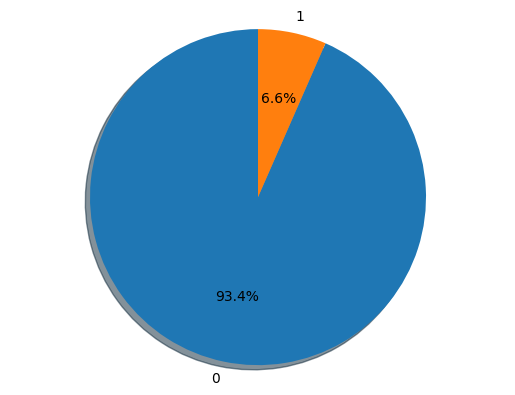

In [2]:
import matplotlib.pyplot as plt

groups = df_full['class'].value_counts()
sizes = [groups[0], groups[1]]
labels = list(map(lambda e: str(e), groups.index))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## Import RuleKit

In [3]:
from rulekit.classification import RuleClassifier
from rulekit.params import Measures

## Helper function for calculating metrics

In [4]:
import sklearn.tree as scikit
from sklearn.datasets import load_iris
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
import pandas as pd
import numpy as np


x = df_full.drop(['class'], axis=1)
y = df_full['class']

def get_prediction_metrics(measure: str, y_pred, y_true, classification_metrics: dict) -> tuple[pd.DataFrame, np.ndarray]:
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    sensitivity = tp  / (tp + fn)
    specificity = tn  / (tn + fp)
    npv = tn  / (tn + fn)
    ppv = tp  / (tp + fp)

    dictionary = {
        'Measure': measure,
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'Kappa': metrics.cohen_kappa_score(y_true, y_pred),
        'Balanced accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Logistic loss': metrics.log_loss(y_true, y_pred),
        'Precision': metrics.log_loss(y_true, y_pred),
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'NPV': npv,
        'PPV': ppv,
        'psep': ppv + npv - 1,
        'Fall-out': fp  / (fp + tn),
        "Youden's J statistic": sensitivity + specificity - 1,
        'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),
        'F-measure': 2 * tp / (2 * tp + fp + fn),
        'Fowlkes-Mallows index': metrics.fowlkes_mallows_score(y_true, y_pred),
        'False positive': fp,
        'False negative': fn,
        'True positive': tp,
        'True negative': tn,
        'Rules per example': classification_metrics['rules_per_example'],
        'Voting conflicts': classification_metrics['voting_conflicts'],
        'Geometric mean': math.sqrt(specificity * sensitivity),
        'Geometric mean': math.sqrt(specificity * sensitivity),
    }
    return pd.DataFrame.from_records([dictionary], index='Measure'), confusion_matrix

def get_ruleset_stats(measure: str, model) -> pd.DataFrame:
    return pd.DataFrame.from_records([{'Measure': measure, **model.stats.__dict__}], index='Measure')
    

## Rule induction on full dataset

In [5]:
from IPython.display import display

# C2
clf = RuleClassifier(
    induction_measure=Measures.C2,
    pruning_measure=Measures.C2,
    voting_measure=Measures.C2,
)
clf.fit(x, y)
c2_ruleset = clf.model
prediction, classification_metrics = clf.predict(x, return_metrics=True)

prediction_metric, c2_confusion_matrix = get_prediction_metrics('C2', prediction, y, classification_metrics)
model_stats = get_ruleset_stats('C2', clf.model)

# Correlation
clf = RuleClassifier(
    induction_measure=Measures.Correlation,
    pruning_measure=Measures.Correlation,
    voting_measure=Measures.Correlation,
)
clf.fit(x, y)
corr_ruleset = clf.model
prediction, classification_metrics = clf.predict(x, return_metrics=True)

tmp, corr_confusion_matrix = get_prediction_metrics('Correlation', prediction, y, classification_metrics)
prediction_metric = pd.concat([prediction_metric, tmp])
model_stats = pd.concat([model_stats, get_ruleset_stats('Correlation', clf.model)])

# RSS
clf = RuleClassifier(
    induction_measure=Measures.RSS,
    pruning_measure=Measures.RSS,
    voting_measure=Measures.RSS,
)
clf.fit(x, y)
rss_ruleset = clf.model
prediction, classification_metrics = clf.predict(x, return_metrics=True)
tmp, rss_confusion_matrix = get_prediction_metrics('RSS', prediction, y, classification_metrics)
prediction_metric = pd.concat([prediction_metric, tmp])
model_stats = pd.concat([model_stats, get_ruleset_stats('RSS', clf.model)])

display(model_stats)
display(prediction_metric)

print('Confusion matrix - C2')
display(pd.DataFrame(c2_confusion_matrix))

print('Confusion matrix - Correlation')
display(pd.DataFrame(corr_confusion_matrix))

print('Confusion matrix - RSS')
display(pd.DataFrame(rss_confusion_matrix))

,time_total_s,time_growing_s,time_pruning_s,rules_count,conditions_per_rule,induced_conditions_per_rule,avg_rule_coverage,avg_rule_precision,avg_rule_quality,pvalue,FDR_pvalue,FWER_pvalue,fraction_significant,fraction_FDR_significant,fraction_FWER_significant
Measure,,,,,,,,,,,,,,,
C2,2.048291,1.768758,0.184968,180,4.166667,14.283333,0.140009,0.917557,0.479462,0.059210,0.064941,0.923494,0.766667,0.750000,0.555556
Correlation,1.930491,1.508517,0.403818,59,4.949153,54.118644,0.394514,0.697542,0.186313,0.030765,0.032032,0.100231,0.881356,0.881356,0.864407
RSS,2.281667,1.847020,0.401133,62,4.016129,46.209677,0.597985,0.840503,0.326838,0.006431,0.006557,0.013879,0.967742,0.951613,0.919355


,Accuracy,MAE,Kappa,Balanced accuracy,Logistic loss,Precision,Sensitivity,Specificity,NPV,PPV,...,Lift,F-measure,Fowlkes-Mallows index,False positive,False negative,True positive,True negative,Rules per example,Voting conflicts,Geometric mean
Measure,,,,,,,,,,,,,,,,,,,,,
C2,0.969040,0.030960,0.688525,0.778376,1.069314,1.069314,0.558824,0.997929,0.969807,0.950000,...,14.440000,0.703704,0.967051,5,75,95,2409,25.201625,841.0,0.746770
Correlation,0.916796,0.083204,0.324961,0.662925,2.873809,2.873809,0.370588,0.955261,0.955657,0.368421,...,5.600000,0.369501,0.912956,108,107,63,2306,23.276316,1850.0,0.594986
RSS,0.926084,0.073916,0.227626,0.588608,2.552999,2.552999,0.200000,0.977216,0.945491,0.382022,...,5.806742,0.262548,0.924802,55,136,34,2359,37.075077,2082.0,0.442090


Confusion matrix - C2


,0,1
0,2409,5
1,75,95


Confusion matrix - Correlation


,0,1
0,2306,108
1,107,63


Confusion matrix - RSS


,0,1
0,2359,55
1,136,34


### C2 Measure generated rules

In [6]:
for rule in c2_ruleset.rules:
    print(rule)

IF gimpuls = (-inf, 32.50) THEN class = {0}
IF gimpuls = (-inf, 54.50) AND senergy = (-inf, 3700) THEN class = {0}
IF gimpuls = (-inf, 54.50) AND genergy = <1865, inf) THEN class = {0}
IF goenergy = <-84.50, inf) AND goimpuls = (-inf, -0.50) AND genergy = (-inf, 13675) AND nbumps = (-inf, 0.50) THEN class = {0}
IF goenergy = <-84.50, inf) AND genergy = (-inf, 17640) AND nbumps = (-inf, 0.50) THEN class = {0}
IF genergy = <1635, 13675) AND goimpuls = (-inf, -0.50) AND nbumps = (-inf, 0.50) THEN class = {0}
IF goenergy = <-84.50, inf) AND gimpuls = (-inf, 772.50) AND genergy = (-inf, 17640) AND senergy = (-inf, 650) THEN class = {0}
IF goenergy = <-84.50, inf) AND maxenergy = (-inf, 950) AND gimpuls = (-inf, 772.50) AND genergy = (-inf, 17640) THEN class = {0}
IF goenergy = <-84.50, inf) AND goimpuls = (-inf, -5.50) AND genergy = (-inf, 13675) AND senergy = (-inf, 2200) AND nbumps2 = (-inf, 0.50) THEN class = {0}
IF goenergy = <-84.50, inf) AND gimpuls = (-inf, 772.50) AND genergy = (-in

### Correlation Measure generated rules

In [7]:
for rule in corr_ruleset.rules:
    print(rule)

IF gimpuls = (-inf, 1252.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1342.50) AND goimpuls = (-inf, 96.50) AND senergy = (-inf, 550) THEN class = {0}
IF gimpuls = (-inf, 1342.50) AND goimpuls = (-inf, 312) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1410) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1653.50) AND genergy = (-inf, 1006585) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1684) AND goimpuls = (-inf, 312) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1798) AND goimpuls = (-inf, 312) AND genergy = (-inf, 1006585) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 2733) AND nbumps2 = (-inf, 0.50) THEN class = {0}
IF gimpuls = (-inf, 3146) AND genergy = (-inf, 1733075) AND goimpuls = (-inf, 312) AND nbumps = (-inf, 1.50) THEN class = {0}
IF goimpuls = (-inf, 312) AND nbumps = (-inf, 1.50) THEN class = {0}
IF senergy = (-inf, 2350) AND nbumps2 = (-inf, 1.50) THEN class = {0}


### RSS Measure generated rules

In [8]:
for rule in rss_ruleset.rules:
    print(rule)

IF genergy = (-inf, 126350) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1210) AND goimpuls = (-inf, 233.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1342.50) AND goimpuls = (-inf, 233.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1410) AND goimpuls = (-inf, 233.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1485) AND goimpuls = (-inf, 96.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1653.50) AND goimpuls = (-inf, 96.50) AND genergy = (-inf, 1006585) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1752) AND goimpuls = (-inf, 96.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF gimpuls = (-inf, 1822) AND goimpuls = (-inf, 96.50) AND nbumps = (-inf, 1.50) THEN class = {0}
IF goenergy = (-inf, 104.50) AND gimpuls = (-inf, 2168) AND goimpuls = (-inf, 96.50) AND senergy = (-inf, 550) THEN class = {0}
IF gimpuls = (-inf, 2733) AND genergy = (-inf, 1026530) AND goimpuls = (-inf

## Stratified K-Folds cross-validation

In [9]:
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10

skf = StratifiedKFold(n_splits=10)


In [10]:
c2_ruleset_stats = pd.DataFrame()
c2_prediction_metrics = pd.DataFrame()
c2_confusion_matrix = np.array([[0.0, 0.0], [0.0, 0.0]])

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RuleClassifier(
        induction_measure=Measures.C2,
        pruning_measure=Measures.C2,
        voting_measure=Measures.C2,
    )
    clf.fit(x_train, y_train)
    c2_ruleset = clf.model
    prediction, classification_metrics = clf.predict(x_test, return_metrics=True)
    tmp, confusion_matrix = get_prediction_metrics('C2', prediction, y_test, classification_metrics)
    
    c2_prediction_metrics = pd.concat([c2_prediction_metrics, tmp])
    c2_ruleset_stats = pd.concat([c2_ruleset_stats, get_ruleset_stats('C2', c2_ruleset)])
    c2_confusion_matrix += confusion_matrix

c2_confusion_matrix /= N_SPLITS

C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ppv = tp  / (tp + fp)
C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:36: RuntimeWarning: invalid value encountered in scalar divide
  'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),
C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ppv = tp  / (tp + fp)
C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:36: RuntimeWarning: invalid value encountered in scalar divide
  'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),
C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ppv = tp  / (tp + fp)
C:\Users\cezar\AppData\Local\Temp\ipykernel_36476\114429488.py:36: RuntimeWarning: invalid value encountered in scalar divide
  'Lift': (tp / (tp + fp)) / ((tp + fn) / (t

Rules characteristics 

In [11]:
display(c2_ruleset_stats.mean())

time_total_s                     1.127413
time_growing_s                   0.937007
time_pruning_s                   0.151819
rules_count                    167.700000
conditions_per_rule              4.135487
induced_conditions_per_rule     13.639392
avg_rule_coverage                0.167726
avg_rule_precision               0.918341
avg_rule_quality                 0.485287
pvalue                           0.046021
FDR_pvalue                       0.049992
FWER_pvalue                      0.603958
fraction_significant             0.806265
fraction_FDR_significant         0.787313
fraction_FWER_significant        0.633591
dtype: float64

Rules evaluation (average)

In [12]:
display(c2_prediction_metrics.mean())

Accuracy                   0.899071
MAE                        0.100929
Kappa                      0.047367
Balanced accuracy          0.535887
Logistic loss              3.486010
Precision                  3.486010
Sensitivity                0.117647
Specificity                0.954127
NPV                        0.939956
PPV                        0.197777
psep                       0.140239
Fall-out                   0.045873
Youden's J statistic       0.071774
Lift                       3.013186
F-measure                  0.073023
Fowlkes-Mallows index      0.901979
False positive            11.100000
False negative            15.000000
True positive              2.000000
True negative            230.300000
Rules per example         24.002394
Voting conflicts         111.300000
Geometric mean             0.180079
dtype: float64

Confusion matrix (average)

In [13]:
display(pd.DataFrame(c2_confusion_matrix))

,0,1
0,230.3,11.1
1,15.0,2.0


## Hyperparameters tuning

This one gonna take a while...

In [14]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from rulekit.params import Measures
# define dataset
import numpy as np

N_SPLITS = 3

# define models and parameters
model = RuleClassifier()
minsupp_new = range(3, 15, 2)
measures_choice = [Measures.C2, Measures.RSS, Measures.WeightedLaplace, Measures.Correlation]
# define grid search
grid = {
    'minsupp_new': minsupp_new, 
    'induction_measure': measures_choice, 
    'pruning_measure': measures_choice, 
    'voting_measure': measures_choice
}
cv = StratifiedKFold(n_splits=N_SPLITS)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='balanced_accuracy')
grid_result = grid_search.fit(x, y)
# summarize results

print("Best BAC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best BAC: 0.626780 using {'induction_measure': <Measures.WeightedLaplace: 'WeightedLaplace'>, 'minsupp_new': 5, 'pruning_measure': <Measures.RSS: 'RSS'>, 'voting_measure': <Measures.WeightedLaplace: 'WeightedLaplace'>}


## Building model with tuned hyperparameters

### Split dataset to train and test (80%/20%).

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
from rulekit.params import Measures

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)


clf = RuleClassifier(**grid_result.best_params_)
clf.fit(x_train, y_train)
ruleset = clf.model
ruleset_stats = get_ruleset_stats('Best', ruleset)

Rules evaluation

In [16]:
display(ruleset_stats.mean())

time_total_s                    0.221808
time_growing_s                  0.183045
time_pruning_s                  0.029816
rules_count                    42.000000
conditions_per_rule             2.404762
induced_conditions_per_rule     9.357143
avg_rule_coverage               0.498744
avg_rule_precision              0.866231
avg_rule_quality                1.103251
pvalue                          0.021661
FDR_pvalue                      0.022077
FWER_pvalue                     0.038384
fraction_significant            0.928571
fraction_FDR_significant        0.928571
fraction_FWER_significant       0.928571
dtype: float64

### Validate model on test dataset

In [17]:
prediction, classification_metrics = clf.predict(x_test, return_metrics=True)
prediction_metrics, confusion_matrix = get_prediction_metrics('Best', prediction, y_test, classification_metrics)

display(prediction_metrics.mean())
display(pd.DataFrame(confusion_matrix))

Accuracy                   0.903288
MAE                        0.096712
Kappa                      0.355362
Balanced accuracy          0.729543
Logistic loss              3.340361
Precision                  3.340361
Sensitivity                0.531250
Specificity                0.927835
NPV                        0.967742
PPV                        0.326923
psep                       0.294665
Fall-out                   0.072165
Youden's J statistic       0.459085
Lift                       5.281851
F-measure                  0.404762
Fowlkes-Mallows index      0.897822
False positive            35.000000
False negative            15.000000
True positive             17.000000
True negative            450.000000
Rules per example         20.839458
Voting conflicts         446.000000
Geometric mean             0.702077
dtype: float64

,0,1
0,450,35
1,15,17
